In [8]:
# Run if you are on Google Colab to install the Python bindings
!bash compile.sh

^C
Traceback (most recent call last):
  File "setup.py", line 1, in <module>
    from setuptools import setup
  File "/Users/wonjunlee/miniconda3/envs/cv/lib/python3.6/site-packages/setuptools/__init__.py", line 16, in <module>
    import setuptools.version
  File "/Users/wonjunlee/miniconda3/envs/cv/lib/python3.6/site-packages/setuptools/version.py", line 1, in <module>
    import pkg_resources
  File "/Users/wonjunlee/miniconda3/envs/cv/lib/python3.6/site-packages/pkg_resources/__init__.py", line 3242, in <module>
    @_call_aside
  File "/Users/wonjunlee/miniconda3/envs/cv/lib/python3.6/site-packages/pkg_resources/__init__.py", line 3226, in _call_aside
    f(*args, **kwargs)
  File "/Users/wonjunlee/miniconda3/envs/cv/lib/python3.6/site-packages/pkg_resources/__init__.py", line 3278, in _initialize_master_working_set
    list(map(working_set.add_entry, sys.path))
  File "/Users/wonjunlee/miniconda3/envs/cv/lib/python3.6/site-packages/pkg_resources/__init__.py", line 608, in add_ent

In [ ]:
import argparse
import os
import numpy as np
import math
import sys
import copy
import matplotlib.pyplot as plt
from screening import HelperClass

import torchvision.transforms as transforms
from torchvision.utils import save_image

from torch.utils.data import DataLoader
from torchvision import datasets
from torch.autograd import Variable

import torch.nn as nn
import torch.nn.functional as F
import torch.autograd as autograd
import torch

cuda = True if torch.cuda.is_available() else False
os.makedirs("images", exist_ok=True)

# Importing functions (Poisson solver, finite difference schemes, c-transform, etc)

In [ ]:
from python_functions.poisson_helper import *
from python_functions.finite_diff_helper import *
from screening import compute_dx, compute_dy, c_transform_cpp, c_transform_forward_cpp , approx_push_cpp, c_transform_epsilon_cpp, compute_nu_and_rho_cpp

In [ ]:
import os
import numpy as np
from scipy.fftpack import dctn, idctn
import math
import sys
import copy

# Initialize Fourier kernel
def initialize_kernel(n1, n2, dy):
    xx, yy = np.meshgrid(np.linspace(0,np.pi,n1,False), np.linspace(0,np.pi,n2,False))
    # kernel = 2*n1*n1*(1-np.cos(xx)) + 2*n2*n2*(1-np.cos(yy))
    kernel = 2*(1-np.cos(xx))/(dy*dy) + 2*(1-np.cos(yy))/(dy*dy)
    kernel[0,0] = 1     # to avoid dividing by zero
    return kernel

# 2d DCT
def dct2(a):
    return dctn(a, norm='ortho')

# 2d IDCT
def idct2(a):
    return idctn(a, norm='ortho')

# Solving Poisson
#   - Δ u = f
#   output: u = (-Δ)⁻¹ f
def solve_poisson(u, f, kernel):
    n = u.shape[0]
    u[:] = 0
    workspace = np.copy(f)
    workspace = dct2(workspace) / kernel
    workspace[0,0] = 0
    u += idct2(workspace)

def solve_poisson_bdry(u, f, bdry, kernel):
    gx0, gx1, gy0, gy1 = bdry
    n = u.shape[0]
    u[:] = 0
    workspace = np.copy(f)
    workspace[0,:]   -= gy0 * n
    workspace[n-1,:] += gy1 * n
    workspace[:,0]   -= gx0 * n
    workspace[:,n-1] += gx1 * n
    workspace = dct2(workspace) / kernel
    workspace[0,0] = 0
    u += idct2(workspace)

# Defining functions

In [ ]:
# performing c transform
# output: modified psi
def c_transform(psi: torch.tensor, phi: torch.tensor, cost: torch.tensor):
  n = phi.shape[0]
  psi[:] = torch.min(cost + phi.view((1,n*n)), dim=1).values.view((n,n))

def c_transform_forward(phi: torch.tensor, psi: torch.tensor, cost: torch.tensor):
  n = phi.shape[0]
  phi[:] = torch.max(- cost + psi.view((n*n,1)), dim=0).values.view((n,n))

# push forward
def approx_push(nu: torch.tensor, psi: torch.tensor, phi: torch.tensor, cost: torch.tensor, epsilon: float, dx: float, dy: float, yMax: float):
  mat   = torch.exp((psi.view((n*n,1)) - phi.view((1,n*n)) - cost) / epsilon) # mat = (n*n, n*n) matrix
  mat  /= torch.sum(mat, dim=1).view((n*n,1)) * (dy*dy)
  nu[:] = torch.sum(mat, dim=0).view((n,n)) * (dx*dx)


def compute_rhs(phi_np, psi_np, nu_np, b, helper, dx, dy, show_image=False):
  n = phi_np.shape[0]
  tmp = np.zeros((n+2,n+2))

  # the following codes compute the gradients using numpy arrays in python
  # phixx = compute_dxx(phi_np, tmp, dy)
  # phiyy = compute_dyy(phi_np, tmp, dy)
  # phixy = compute_dxy(phi_np, tmp, dy)
  # fx = compute_dx(phi_np-b, tmp, dy)
  # fy = compute_dy(phi_np-b, tmp, dy)

  # the following codes compute the gradients using through C++
  #   initialize fx, fy
  fx = np.zeros((n, n))
  fy = np.zeros((n, n))

  phi_b = phi_np-b
  compute_dx(fx, phi_b, dy)
  compute_dy(fy, phi_b, dy)

#   det = phixx * phiyy - phixy * phixy
#   R1 = nu_np * (  phiyy * fx - phixy * fy) / det
#   R2 = nu_np * (- phixy * fx + phixx * fy) / det

  R1  = np.zeros((n,n))
  R2  = np.zeros((n,n))
  R1x = np.zeros((n,n))
  R2y = np.zeros((n,n))

  helper.compute_inverse_g(R1, R2, phi_np, psi_np, fx, fy)

  R1_nu = nu_np * R1
  R2_nu = nu_np * R2

  # R1x = compute_dx_forward(R1, tmp, dy)
  # R2y = compute_dy_forward(R2, tmp, dy)

  compute_dx(R1x, R1_nu, dy)
  compute_dy(R2y, R2_nu, dy)

  gx0 = -R1_nu[:,0]
  gx1 = -R1_nu[:,-1]

  gy0 = -R2_nu[0,:]
  gy1 = -R2_nu[-1,:]

  # fig,ax = plt.subplots(1,5,figsize=(17,4))
  # ax[0].imshow(R1_nu,origin='lower')
  # ax[0].set_title("R1")
  # ax[1].imshow(R2_nu,origin='lower')
  # ax[1].set_title("R2")
  # ax[2].imshow(R1x,origin='lower')
  # ax[2].set_title("R1x")
  # ax[3].imshow(R2y,origin='lower')
  # ax[3].set_title("R2y")
  # ax[4].imshow(nu_np,origin='lower')
  # ax[4].set_title("nu_np")
  # plt.show()

  return nu_np + R1x + R2y, [gx0,gx1,gy0,gy1], R1, R2, R1x, R2y


def solve_poisson(u, phi_np, psi_np, nu_np, b, kernel, helper, dx, dy, yMax, show_image=False):
  rhs, bdry, R1, R2, R1x, R2y = compute_rhs(phi_np, psi_np, nu_np, b, helper, dx, dy, show_image=show_image) # computing the right hand side
  solve_poisson_bdry(u,rhs,bdry,kernel)
  return rhs, R1, R2, R1x, R2y

size of cost:  (4096, 4096)


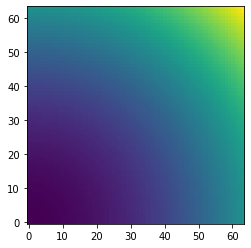

N: 4096 Hello, World!



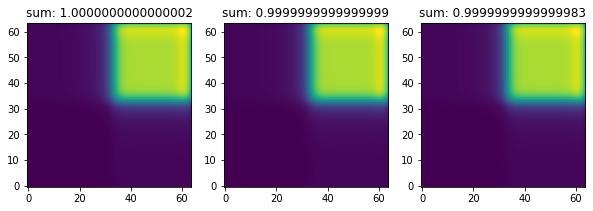

In [ ]:
from IPython import display

# parameters
# grid size n x n
n = 64

# step size for the gradient ascent
L = 1000

# epsilon for pushforward
epsilon = 5e-3
max_iteration = 10000000

X, Y = np.meshgrid(np.linspace(0.5/n,1-0.5/n,n), np.linspace(0.5/n,1-0.5/n,n))

Xx = X + 1
Xy = Y + 1
yMax = 2
Yx = yMax * X
Yy = yMax * Y

dx = 1.0/n
dy = dx * yMax

# kernel = initialize_kernel(n, n, dy)
kernel = initialize_kernel(n, n, 1.0/n*yMax)

Xv = np.zeros((n*n,2))
Xv[:,0] = Xx.reshape((n*n,))
Xv[:,1] = Xy.reshape((n*n,))

Yv = np.zeros((n*n,2))
Yv[:,0] = Yx.reshape((n*n,))
Yv[:,1] = Yy.reshape((n*n,))

cost_np = - np.sum(Xv.reshape((n*n,1,2)) * Yv.reshape((1,n*n,2)),axis=2)
print("size of cost: ", cost_np.shape)
b_np    = 0.5 * (Yx**2 + Yy**2)
plt.imshow(b_np,origin='lower')
plt.show()

psi_np     = - 0.5*(Xx**2+Xy**2)
phi_np     = np.zeros((n,n))
nu_np      = np.zeros((n,n))
psi_eps_np = np.zeros((n,n))
rho_np     = np.zeros((n,n))

c_transform_forward_cpp(phi_np, psi_np, cost_np)

# phi  = torch.from_numpy(phi).type(torch.float32)
cost = torch.from_numpy(cost_np)
phi  = torch.from_numpy(phi_np)
psi  = torch.from_numpy(psi_np)
nu   = torch.from_numpy(nu_np)

c_transform_forward(phi, psi, cost)

fig,ax = plt.subplots(1,3,figsize=(10,5))

approx_push_cpp(nu_np, psi_np, phi_np, cost_np, epsilon, dx, dy, yMax)
ax[0].imshow(nu_np, origin='lower')
ax[0].set_title(f"sum: {np.sum(nu_np)*dy*dy}")
 
approx_push(nu, psi, phi, cost, epsilon, dx, dy, yMax)
ax[1].imshow(nu, origin='lower')
ax[1].set_title(f"sum: {torch.sum(nu)*dy*dy}")

rho_np = np.zeros((n,n))
c_transform_epsilon_cpp(psi_eps_np, psi_np, phi_np, cost_np, epsilon, dx, dy, yMax)
compute_nu_and_rho_cpp(nu_np, rho_np, psi_eps_np, phi_np,  cost_np, b_np, epsilon, dx, dy, yMax)
ax[2].imshow(nu_np, origin='lower')
ax[2].set_title(f"sum: {np.sum(nu_np)*dy*dy}")

plt.show()

helper = HelperClass(phi, dx, dy)

u = np.zeros((n,n))

if cuda:
  phi  = phi.cuda()
  psi  = psi.cuda()
  cost = cost.cuda()
  nu   = nu.cuda()

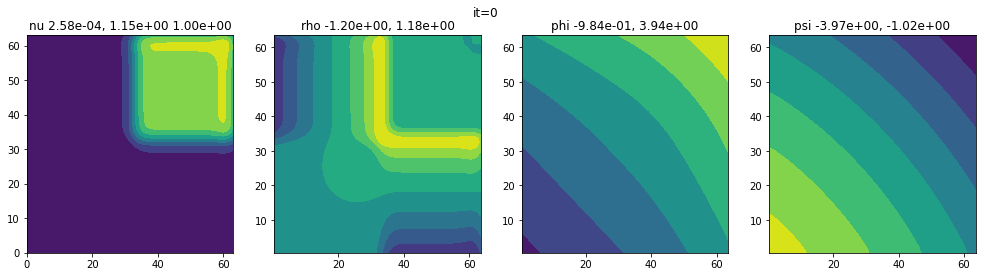

N: 4096 Hello, World!

N: 4096 Hello, World!

N: 4096 Hello, World!

N: 4096 Hello, World!

N: 4096 Hello, World!

N: 4096 Hello, World!



KeyboardInterrupt: 

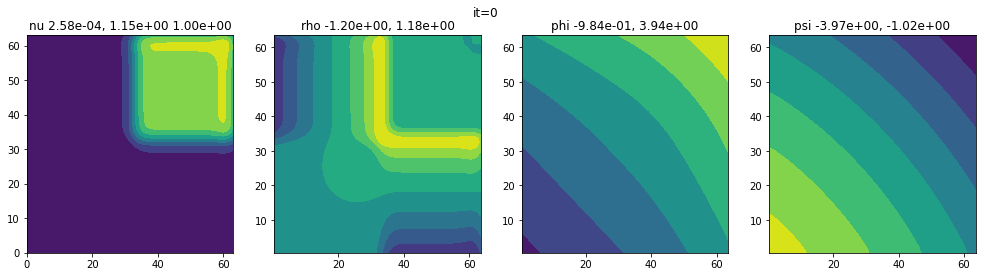

In [ ]:
fig,ax = plt.subplots(1,4,figsize=(17,4))
hdisplay = display.display("", display_id=True)

for it in range(max_iteration):
  c_transform(psi, phi, cost)
  # c_transform_cpp(psi_np, phi_np, cost_np)
  c_transform_epsilon_cpp(psi_eps_np, psi_np, phi_np, cost_np, epsilon, dx, dy, yMax)
  compute_nu_and_rho_cpp(nu_np, rho_np, psi_eps_np, phi_np,  cost_np, b_np, epsilon, dx, dy, yMax)

  # gradient ascent
  # phi_np += 1.0/L * (np.log(1+nu_np) - np.log(1+rho_np))

  # approx_push_cpp(nu_np, psi_np, phi_np, cost_np, epsilon, dx, dy, yMax)
  phi_np += 1.0/L * (nu_np - rho_np)
  # phi_np += 1.0/L * np.log(nu_np - rho_np)

  if it % 10 == 0:
    # ax[0].imshow(nu_np,origin='lower')
    ax[0].contourf(nu_np)
    ax[0].set_title(f"nu {np.min(nu_np):0.2e}, {np.max(nu_np):0.2e} {np.sum(nu_np)*dy**2:0.2e}")
    ax[1].contourf(rho_np,origin='lower')
    ax[1].set_title(f"rho {np.min(rho_np):0.2e}, {np.max(rho_np):0.2e}")
    ax[2].contourf(phi_np,origin='lower')
    ax[2].set_title(f"phi {np.min(phi_np):0.2e}, {np.max(phi_np):0.2e}")
    ax[3].contourf(psi_eps_np,origin='lower')
    ax[3].set_title(f"psi {np.min(psi_np):0.2e}, {np.max(psi_np):0.2e}")
    plt.suptitle(f"it={it}")
    plt.savefig(f"images/{it//10:03d}.png")
    # plt.show()
    hdisplay.update(fig)

In [ ]:
import glob
import cv2

img_array = []
for filename in glob.glob('./images/*.png'):
    img = cv2.imread(filename)
    height, width, layers = img.shape
    size = (width,height)
    img_array.append(img)


out = cv2.VideoWriter('project.mp4',cv2.VideoWriter_fourcc(*'DIVX'), 15, size)

for i in range(len(img_array)):
    out.write(img_array[i])
out.release()

from IPython.display import Video
Video("project.mp4")

In [ ]:
!rm images/*
